In [1]:
import h2o, re, emoji, string
from wordcloud import STOPWORDS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu120.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu120.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp7bv3czyd
  JVM stdout: /tmp/tmp7bv3czyd/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp7bv3czyd/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,2 months and 13 days
H2O_cluster_name:,H2O_from_python_unknownUser_zt9kbs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.500 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


# 1. Overview

In [2]:
import pandas as pd

spam_df = pd.read_csv("/kaggle/input/spam-mails-dataset/spam_ham_dataset.csv")
spam_df.columns = ['id', 'label', 'text', 'result']
spam_df = spam_df[['result', 'text']].dropna()
spam_df['result'] = spam_df['result'].replace({0: 'Not-spam', 1: 'Spam'})
spam_df.head()

,result,text
0,Not-spam,Subject: enron methanol ; meter # : 988291\r\n...
1,Not-spam,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,Not-spam,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,Spam,"Subject: photoshop , windows , office . cheap ..."
4,Not-spam,Subject: re : indian springs\r\nthis deal is t...


Firstly, we will try on the general-quantitives features from the input (like `number of words / unique words`, or `max length of word`, `number of emails, hastags, punctuations, etc`

In [3]:
def regex_transform(data, text_col):
        
    fs_emj = [":)", ":v", "=))", ":v", ":3", ":(", ":((", ":'("]          
    # 1. word_count
    data['wcount'] = data[text_col].apply(lambda x: len(str(x).split()))
    # 2. unique_word_count
    data['unq_wcount'] = data[text_col].apply(lambda x: len(set(str(x).split())))
    # 3. stop_word_count
    data['stop_word_count'] = data[text_col].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    # 4. url_count
    data['url_count'] = data[text_col].apply(lambda x: len(re.findall(r"https|www|http", x)))
    # 5. average_word_length
    data['avg_wlen'] = data[text_col].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    # 6. char_count
    data['char_count'] = data[text_col].apply(lambda x: len(str(x)))
    # 7. punctuation_count
    punctuations = string.punctuation
    data['punct_count'] = data[text_col].apply(lambda x: len([c for c in str(x) if c in punctuations]))
    # 8. hashtag_count
    data['hastg_count'] = data[text_col].apply(lambda x: len([c for c in str(x) if c == '#']))
    # 9. mention_count
    data['mentn_count'] = data[text_col].apply(lambda x: len([c for c in str(x) if c == '@']))
    # 10. max length of word
    data['max_wlen'] = data[text_col].apply(lambda x: max([len(w) for w in str(x).split()]))
    # 11. count emoji
    data['emoji_cnt'] = data[text_col].apply(lambda x: len([c for c in str(x).split() if c in fs_emj]))
    data['emoji_cnt'] = data['emoji_cnt'] + data[text_col].apply(lambda x: len(re.compile(r'\d+(.*?)[\u263a-\U0001f645]').findall(x)))
    # 12.count the capital-words
    data['capt_cnt'] = data[text_col].apply(lambda x: sum(1 for c in x if c.isupper()))
    # 13. count the email
    data['email_cnt'] = data[text_col].apply(lambda x: len(re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", x) ))
    # 15. count digits+characters
    data['char&num_cnt'] = data[text_col].apply(lambda x: len(re.findall(r"([A-Za-z]+[\d@]+[\w@]*|[\d@]+[A-Za-z]+[\w@]*)", x) )) - data['mentn_count']
    # 16. max ratio digits of word in each text
    data['max_digit_rate'] = data[text_col].apply(lambda x: max([len(re.findall(r"[0-9]", word) ) / 
                                                                 abs(len(word) - len(re.findall(r"[0-9]", word)))
                                                                    if 
                                                                         len(word) - len(re.findall(r"[0-9]", word)) != 0
                                                                    else 
                                                                         len(re.findall(r"[0-9]", word) ) 
                                                                for word in x
                                                                ])
                                                 )
    data['tab_newlines'] = data[text_col].apply(lambda x: len(re.findall(r"\t|\n", x)))
    return data

## 2. H2o vs regex only

In [4]:
%time spam_df_re = regex_transform(spam_df, 'text')
spam_df_re.head()

CPU times: user 31.3 s, sys: 9.02 ms, total: 31.3 s
Wall time: 31.7 s


,result,text,wcount,unq_wcount,stop_word_count,url_count,avg_wlen,char_count,punct_count,hastg_count,mentn_count,max_wlen,emoji_cnt,capt_cnt,email_cnt,char&num_cnt,max_digit_rate,tab_newlines
0,Not-spam,Subject: enron methanol ; meter # : 988291\r\n...,67,57,17,0,3.820896,327,15,1,0,11,0,1,0,0,1.0,5
1,Not-spam,"Subject: hpl nom for january 9 , 2001\r\n( see...",23,19,1,0,3.173913,97,8,0,0,8,0,1,0,0,1.0,2
2,Not-spam,"Subject: neon retreat\r\nho ho ho , we ' re ar...",550,227,243,1,3.574545,2524,82,0,0,11,0,1,0,0,1.0,9
3,Spam,"Subject: photoshop , windows , office . cheap ...",48,46,0,0,7.416667,414,5,0,0,15,0,1,0,0,0.0,10
4,Not-spam,Subject: re : indian springs\r\nthis deal is t...,70,53,32,0,3.757143,336,7,0,0,13,0,1,0,0,0.0,4


#### Split dataframe into train-valid

In [5]:
all_data = h2o.H2OFrame(spam_df_re.drop(columns='text'))
all_data = all_data[all_data['result'].isin(['Spam', 'Not-spam'])]
train, valid = all_data.split_frame(ratios = [.7], seed = 1234)
train_df = train.as_data_frame()
valid_df = valid.as_data_frame()
train.nrows, valid.nrows

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


(3630, 1541)

### EDA charts

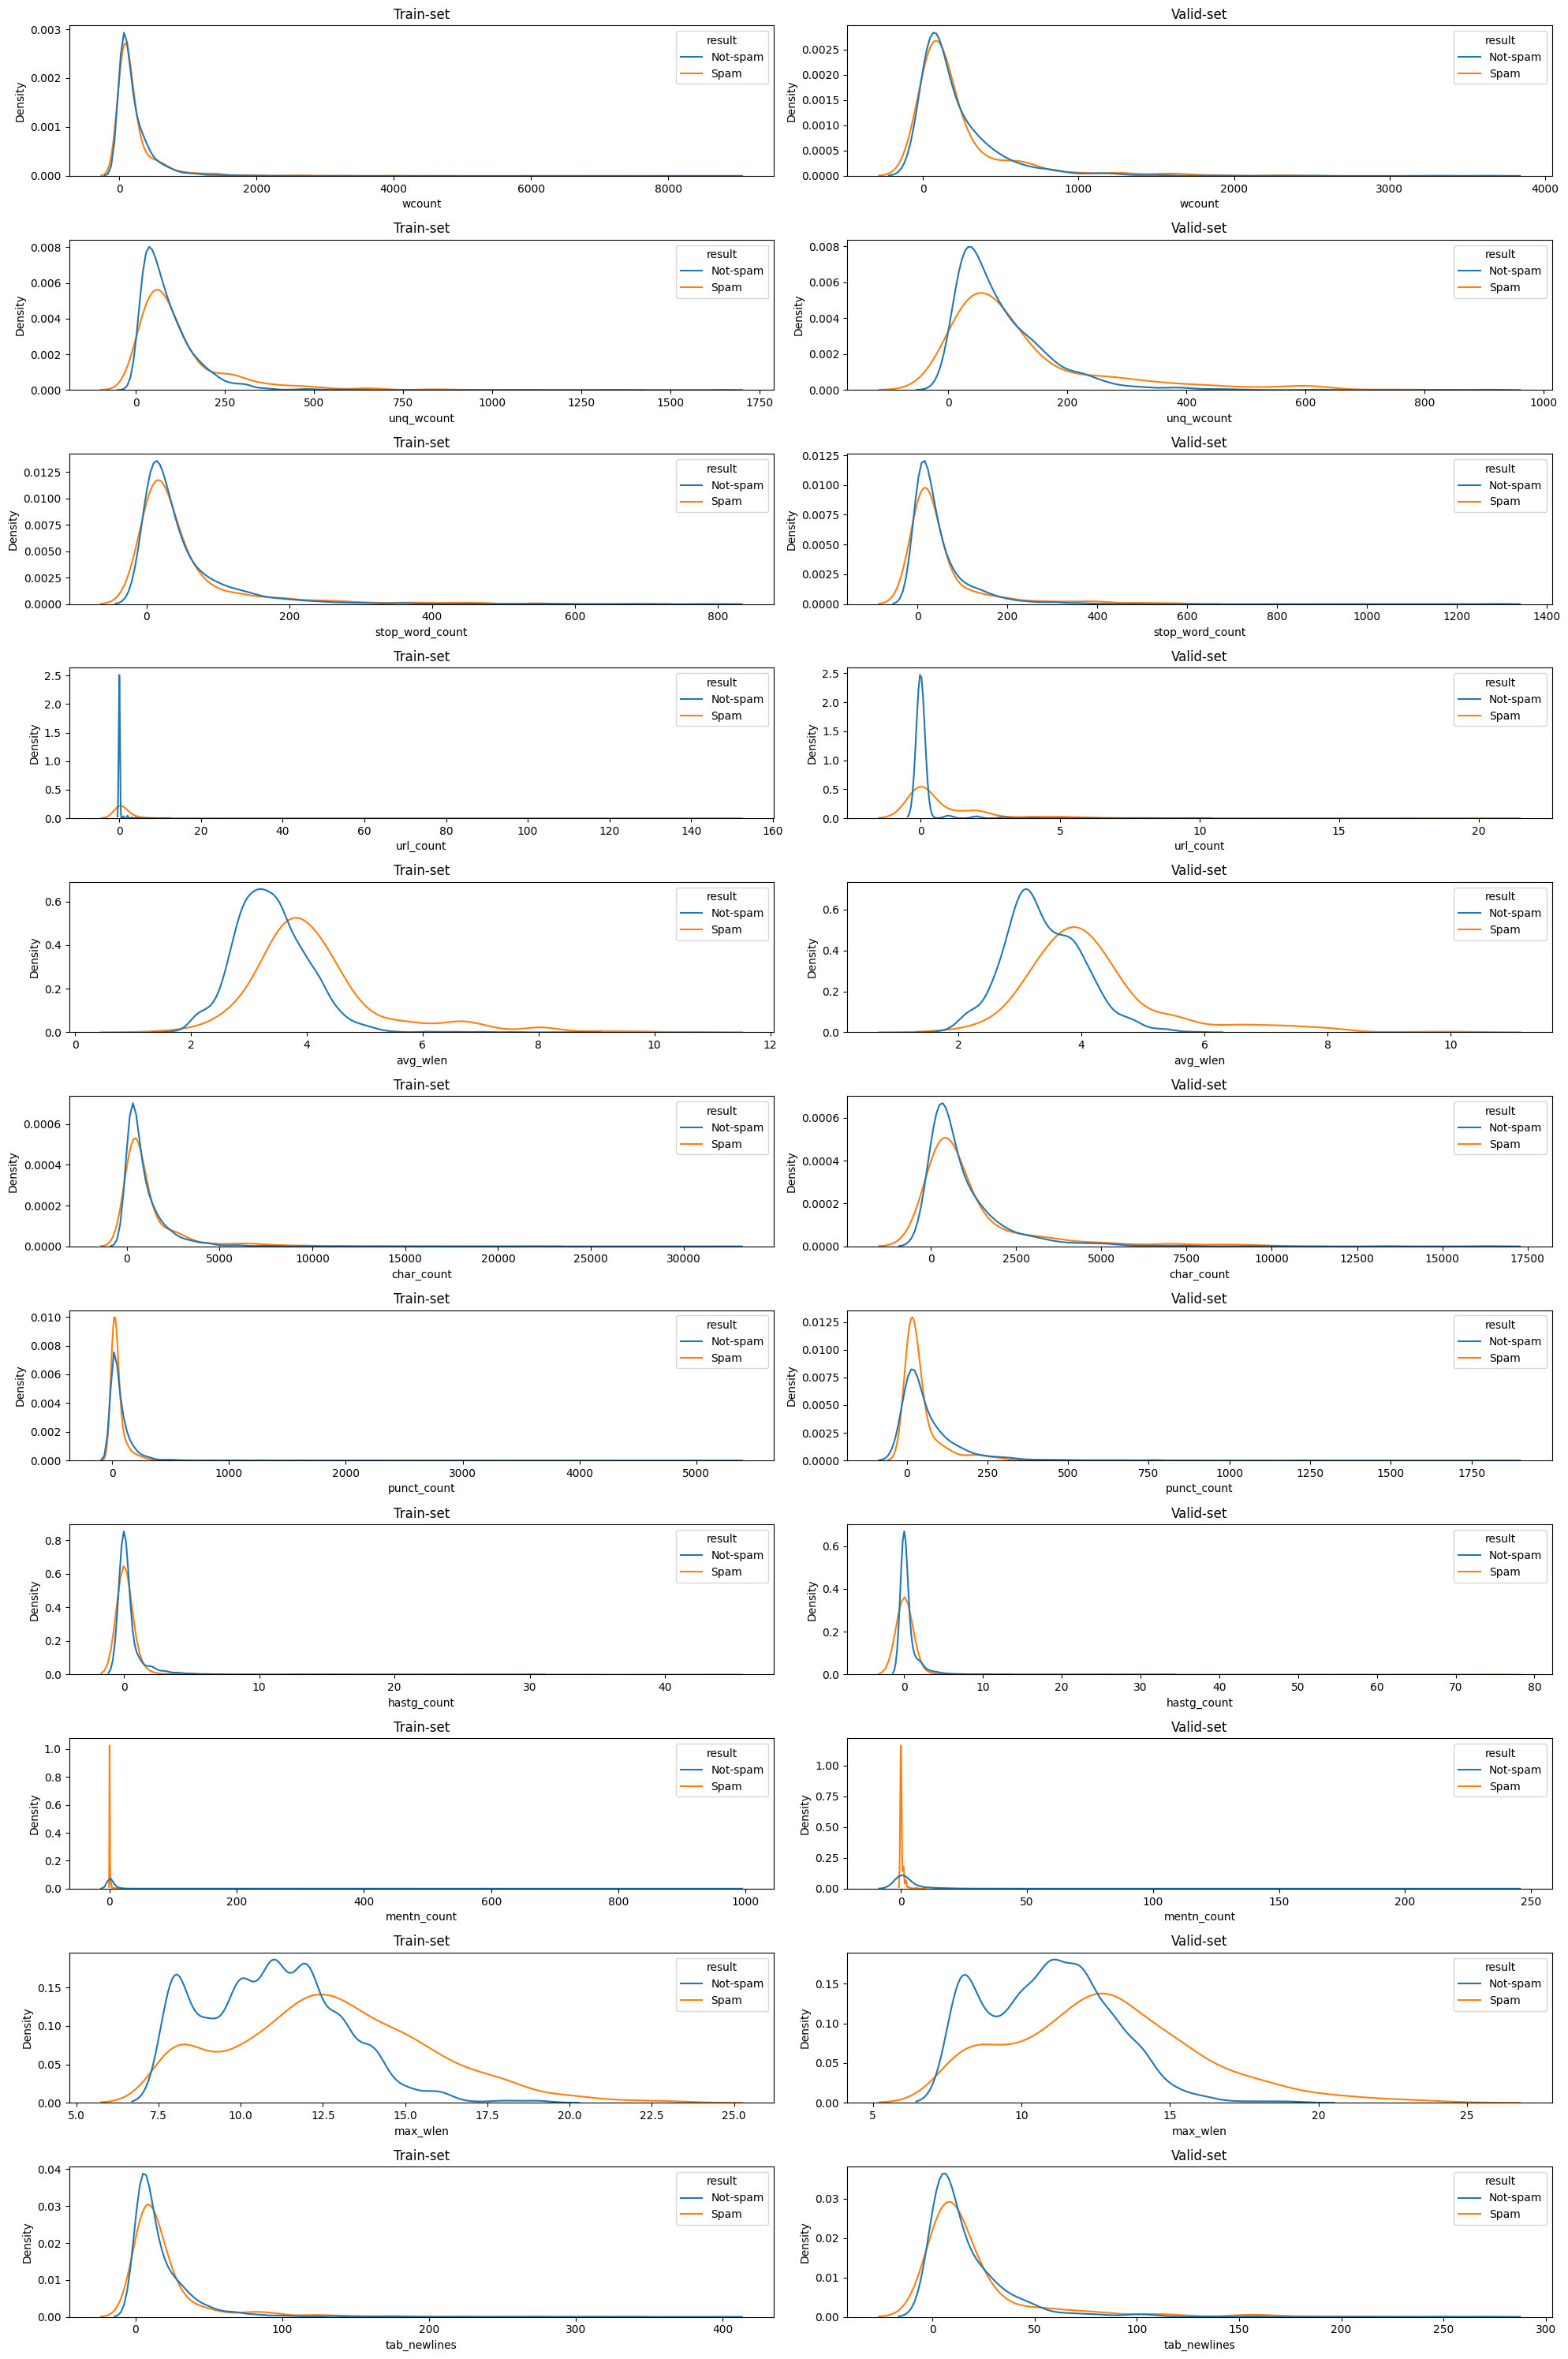

In [6]:
import warnings
warnings.filterwarnings("ignore")
# we will ignore the features that is zero almost everywhere
col = spam_df_re.max()[2:]
col_to_show = col[col.values > 1]
# Plot
fig, axes = plt.subplots(len(col_to_show), 2, figsize=(20, 30))
axes = axes.ravel()
for idx, col in enumerate(col_to_show.index):
    sns.kdeplot(train_df, x=col, hue='result', hue_order=['Not-spam','Spam'], common_norm=False, ax=axes[2*idx])
    sns.kdeplot(valid_df, x=col, hue='result', hue_order=['Not-spam','Spam'], common_norm=False, ax=axes[2*idx+1])
    axes[2*idx].set_title("Train-set")
    axes[2*idx + 1].set_title("Valid-set")
plt.tight_layout()

### Using H2o ML algorithms into this dataset to find the best algo

In [7]:
from h2o.automl import H2OAutoML
# callh20automl function 
my_model = H2OAutoML(max_runtime_secs = 600, # nfolds = 4,
                    #stopping_metric ='auc',
                    sort_metric = 'accuracy',
                    balance_classes = False, max_models=25
)
my_model.train(x=col_to_show.index.tolist(), y='result', 
               training_frame=train, validation_frame=valid)
# Show leaderboard
leadbd = my_model.leaderboard
leadbd

AutoML progress: |
03:41:23.184: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%


model_id,accuracy,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GLM_1_AutoML_1_20240305_34123,0.82011,0.848266,0.428278,0.7263,0.240924,0.366768,0.134519
XGBoost_grid_1_AutoML_1_20240305_34123_model_1,0.842424,0.902296,0.353899,0.80235,0.183302,0.334214,0.111699
DeepLearning_1_AutoML_1_20240305_34123,0.845179,0.882789,0.38218,0.78323,0.20147,0.343463,0.117967
GBM_grid_1_AutoML_1_20240305_34123_model_4,0.855372,0.911936,0.337631,0.813194,0.174268,0.326492,0.106597
XGBoost_grid_1_AutoML_1_20240305_34123_model_3,0.862259,0.915238,0.329726,0.823545,0.166002,0.321651,0.103459
DeepLearning_grid_1_AutoML_1_20240305_34123_model_1,0.863361,0.900217,0.403266,0.814979,0.172881,0.327517,0.107267
XGBoost_grid_1_AutoML_1_20240305_34123_model_5,0.864463,0.919802,0.321642,0.830547,0.158271,0.316942,0.100452
XGBoost_grid_1_AutoML_1_20240305_34123_model_2,0.866942,0.924216,0.311515,0.843478,0.163914,0.312311,0.0975381
GBM_grid_1_AutoML_1_20240305_34123_model_3,0.86832,0.923546,0.317082,0.841264,0.168576,0.314403,0.098849
GBM_1_AutoML_1_20240305_34123,0.869146,0.924117,0.31191,0.842572,0.157868,0.312628,0.0977361


### Top variable-importance

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Best model: GBM_grid_1_AutoML_1_20240305_34123_model_1


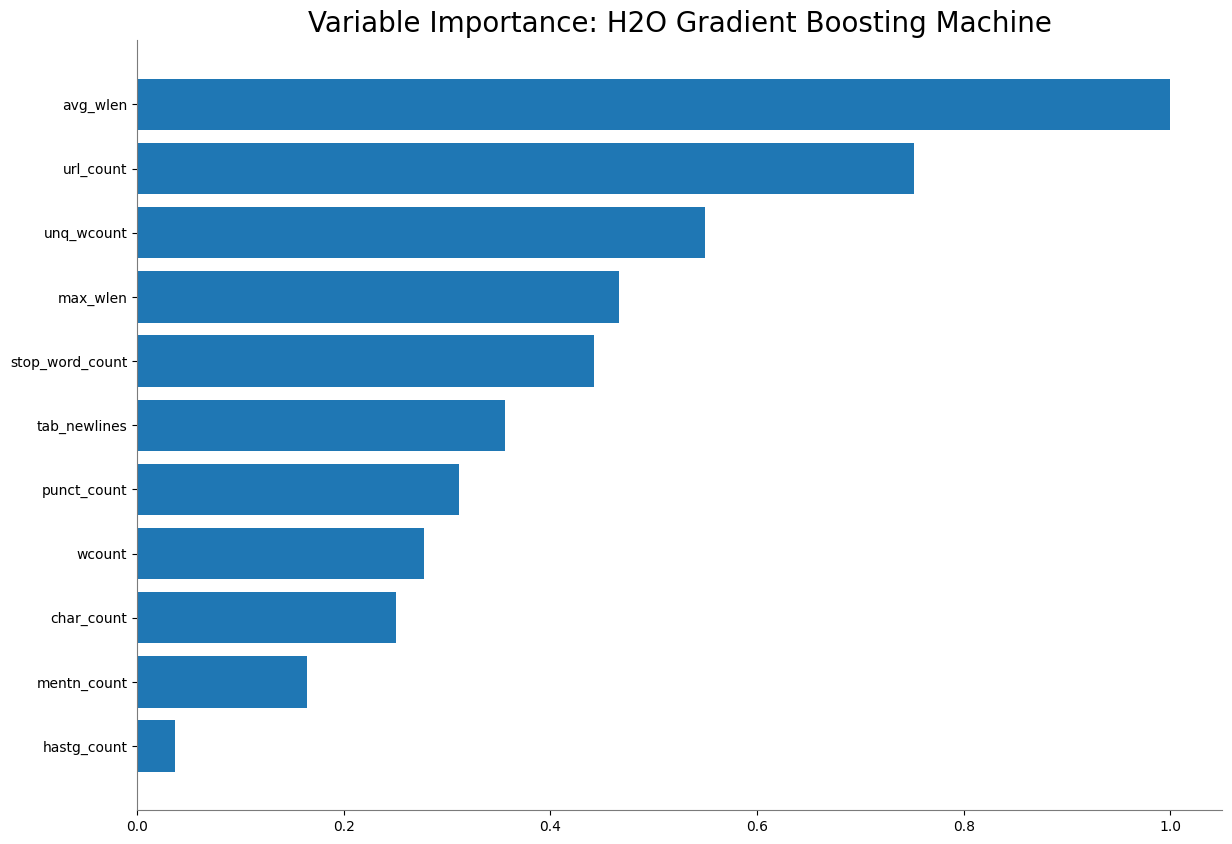

In [8]:
list_model = np.array(h2o.as_list(leadbd['model_id'])).tolist()
list_model = [model_name[0] for model_name in list_model]
print(f"Best model: {list_model[-1]}")
best_model = h2o.get_model(list_model[-1])
res = best_model.varimp_plot(num_of_features = 15, server=True)
res.figure()

In [9]:
best_model.confusion_matrix(valid=True)

,Not-spam,Spam,Error,Rate
Not-spam,1019.0,72.0,0.066,(72.0/1091.0)
Spam,80.0,370.0,0.1778,(80.0/450.0)
Total,1099.0,442.0,0.0986,(152.0/1541.0)


## 3. H2o including Tfidf
In the previous step, we considered (and counted) the `number of character, punctuation, digits, email, hashtag,etc` so we will apply the new features Tfidf after removing these features
#### 3.1. Text pre-processing
For instance, now looking at the number of columns in Tfidf-results without pre-processing text-input

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def tfidf_df_transform(data, text_col):
    word_list = data[text_col].values.tolist()
    cvect = CountVectorizer()
    X_cvect = cvect.fit_transform(word_list)
    X_tfidf = TfidfTransformer().fit_transform(X_cvect)
    spam_re_tf = pd.DataFrame(data = X_tfidf.toarray(),
                              columns = cvect.get_feature_names_out(),
                              index = word_list 
                            )
    return spam_re_tf
len(tfidf_df_transform(spam_df, 'text').columns)

50447

#### Define text-preprocessing function

In [11]:
def text_pre_processing(text):
    # Remove all stopwords
    text = re.compile(r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*').sub(r'', text.lower())
    ## 1. Remove url_link & html
    remove_url = re.compile(r'https?://\S+|www\.\S+').sub(r'', text)
    remove_html = re.compile(r'<.*?>').sub(r'', remove_url)
    ## 2. Remove digits, tabs, new-lines
    remove_html = re.compile(r'[0-9]|\t|\n').sub(r'', remove_html)    
    ## 3. Remove Emojis
    remove_emo = re.compile(r'\d+(.*?)[\u263a-\U0001f645]').sub(r'', remove_html)
    words = re.sub(r"[^A-Za-z0-9\-]", " ", remove_emo).lower().split()    
    return ' '.join(words)

spam_df['text_processed'] = spam_df['text'].map(text_pre_processing).values.tolist()
%time spam_tfidf = tfidf_df_transform(spam_df, 'text_processed')
len(spam_tfidf.columns)

CPU times: user 1.26 s, sys: 844 ms, total: 2.1 s
Wall time: 2.1 s


45604

Using `text-preprocessing` not only lets you avoid some repetitious features that are not necessary, but also reduces the number of vocalbularies in the output (from 50000 to 45604)

### Apply PCA to reduce the dimension 

In [12]:
word_list = spam_df['text_processed'].values.tolist()
cvect = CountVectorizer()
X_cvect = cvect.fit_transform(word_list)
x_tfidf = TfidfTransformer()
X_tfidf = x_tfidf.fit_transform(X_cvect)
spam_tfidf = pd.DataFrame(data = X_tfidf.toarray(),
                          columns = cvect.get_feature_names_out(),
                          index = word_list 
                        )
spam_tfidf.shape

(5171, 45604)

We generate `cvect` because we will apply this to transform the new input in the later step

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=250)
%time spam_tfidf_pca = pd.DataFrame(data = pca.fit_transform(spam_tfidf.to_numpy()))
spam_tfidf_pca.columns = [f"PC_{k+1}" for k in range(250)]
spam_tfidf_pca.head()

CPU times: user 2min 53s, sys: 12.6 s, total: 3min 6s
Wall time: 51.2 s


,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_241,PC_242,PC_243,PC_244,PC_245,PC_246,PC_247,PC_248,PC_249,PC_250
0,0.007252,-0.062888,0.062937,0.029805,0.073449,0.085408,0.030333,-0.078829,-0.000294,0.013089,...,-0.018836,0.014787,0.029898,0.037905,0.008443,-0.036322,0.083570,0.039486,-0.051493,-0.040086
1,-0.356119,0.295528,-0.153602,-0.013565,-0.012100,-0.020426,0.048345,-0.002487,0.066354,0.113099,...,0.000796,-0.001832,0.002947,0.001535,-0.001638,-0.003810,0.003424,0.004378,-0.000973,-0.000155
2,-0.017142,-0.120711,-0.020625,-0.027530,-0.037099,-0.041944,-0.023417,-0.018261,-0.011590,0.004449,...,-0.027279,0.002992,0.046968,-0.032626,-0.002505,-0.048768,0.010635,0.044260,-0.014225,0.022244
3,-0.031932,-0.096857,-0.015701,-0.025658,-0.042111,-0.027647,-0.016855,-0.006532,-0.018942,0.014171,...,0.007978,0.001657,-0.008781,-0.013896,0.005426,0.001749,-0.009686,-0.006031,-0.005668,0.000157
4,-0.009724,-0.065219,0.105236,-0.025344,0.147483,-0.029924,0.000192,-0.002452,-0.037872,0.007707,...,0.018384,-0.001353,0.001077,-0.025252,-0.023610,-0.000294,-0.030922,0.005898,0.044826,-0.047416


### Concatenate

In [14]:
spam_re_tfidf = pd.concat([spam_df_re, 
                           spam_tfidf_pca.reset_index(drop=True)], 
                           axis=1).drop(columns=['text', 'text_processed'])
spam_re_tfidf.head()

,result,wcount,unq_wcount,stop_word_count,url_count,avg_wlen,char_count,punct_count,hastg_count,mentn_count,...,PC_241,PC_242,PC_243,PC_244,PC_245,PC_246,PC_247,PC_248,PC_249,PC_250
0,Not-spam,67,57,17,0,3.820896,327,15,1,0,...,-0.018836,0.014787,0.029898,0.037905,0.008443,-0.036322,0.083570,0.039486,-0.051493,-0.040086
1,Not-spam,23,19,1,0,3.173913,97,8,0,0,...,0.000796,-0.001832,0.002947,0.001535,-0.001638,-0.003810,0.003424,0.004378,-0.000973,-0.000155
2,Not-spam,550,227,243,1,3.574545,2524,82,0,0,...,-0.027279,0.002992,0.046968,-0.032626,-0.002505,-0.048768,0.010635,0.044260,-0.014225,0.022244
3,Spam,48,46,0,0,7.416667,414,5,0,0,...,0.007978,0.001657,-0.008781,-0.013896,0.005426,0.001749,-0.009686,-0.006031,-0.005668,0.000157
4,Not-spam,70,53,32,0,3.757143,336,7,0,0,...,0.018384,-0.001353,0.001077,-0.025252,-0.023610,-0.000294,-0.030922,0.005898,0.044826,-0.047416


Again, split this into train and validation sets

In [15]:
all_data2 = h2o.H2OFrame(spam_re_tfidf)
train2, valid2 = all_data2.split_frame(ratios = [.7], seed = 1234)
train2['result'].unique()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


C1
Not-spam
Spam


Then apply AutoML

In [16]:
my_model2 = H2OAutoML(max_runtime_secs = 600, nfolds = 4,
                    sort_metric = 'accuracy',
                    balance_classes = False, max_models=40
)
my_model2.train(x=spam_re_tfidf.drop(columns= ['emoji_cnt', 'email_cnt', 'capt_cnt']).columns[1:].tolist(), 
                y='result', training_frame=train2, validation_frame=valid2)
# Show leaderboard
leadbd2 = my_model2.leaderboard
leadbd2

AutoML progress: |
03:52:34.145: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%


model_id,accuracy,auc,logloss,aucpr,mean_per_class_error,rmse,mse
DRF_1_AutoML_2_20240305_35234,0.975758,0.995661,0.119568,0.986703,0.0286474,0.160233,0.0256748
XRT_1_AutoML_2_20240305_35234,0.976584,0.996329,0.112525,0.989056,0.028915,0.159279,0.0253697
DeepLearning_1_AutoML_2_20240305_35234,0.977961,0.995483,0.0900491,0.988115,0.0290781,0.138169,0.0190906
XGBoost_2_AutoML_2_20240305_35234,0.978237,0.996786,0.0614333,0.99113,0.026621,0.129612,0.0167993
GBM_5_AutoML_2_20240305_35234,0.978237,0.997374,0.0620979,0.993011,0.0260551,0.131873,0.0173904
GBM_2_AutoML_2_20240305_35234,0.978512,0.997557,0.0583937,0.993567,0.0193542,0.128657,0.0165526
XGBoost_1_AutoML_2_20240305_35234,0.979063,0.99674,0.0634597,0.991438,0.0229277,0.129766,0.0168392
GBM_3_AutoML_2_20240305_35234,0.979339,0.997414,0.0596008,0.992475,0.0278265,0.12847,0.0165046
XGBoost_grid_1_AutoML_2_20240305_35234_model_2,0.979614,0.997286,0.0575966,0.991247,0.0221681,0.125578,0.0157698
XGBoost_3_AutoML_2_20240305_35234,0.979614,0.997391,0.0570105,0.992141,0.0225402,0.125429,0.0157324


### Evaluation

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Best model: GLM_1_AutoML_2_20240305_35234


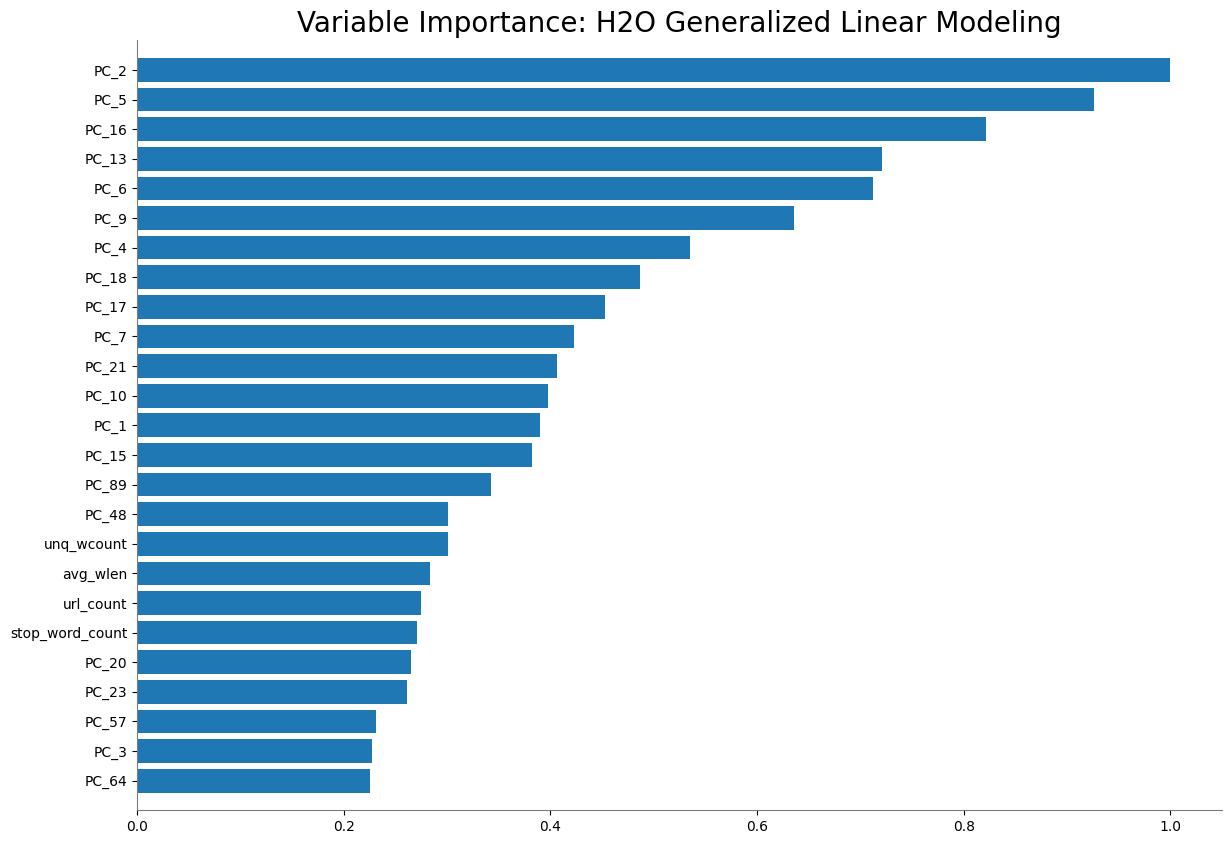

In [17]:
list_model2 = np.array(h2o.as_list(leadbd2['model_id'])).tolist()
list_model2 = [model_name[0] for model_name in list_model2]
print(f"Best model: {list_model2[-1]}")
best_model2 = h2o.get_model(list_model2[-1])
res2 = best_model2.varimp_plot(num_of_features = 25, server=True)
res2.figure()

In [18]:
best_model2.confusion_matrix(valid=True)

,Not-spam,Spam,Error,Rate
Not-spam,1072.0,19.0,0.0174,(19.0/1091.0)
Spam,5.0,445.0,0.0111,(5.0/450.0)
Total,1077.0,464.0,0.0156,(24.0/1541.0)


### Predict new values
Since in this step we have implemented many transformation (`text_preprocessing`, `Tfidf` and `PCA`), so for any new response we must to apply the 2 initialize object `xvect` and `pca` that we have used before adding it into the current model

In [19]:
new_text_emails = ['Subject: machine learning , deep learning , time-series, computer vision \n\n dear Abu Bakr Bủhan \nI didnt like this arward \n regards', 
                   "Subject: re : chinatown\r\nthis deal is to shittime the teco pvr revenue . it isnt my understanding that teco\r\njust sends us a check"]
new_text_df = pd.DataFrame({'new_text': new_text_emails})
new_text_df

,new_text
0,"Subject: machine learning , deep learning , ti..."
1,Subject: re : chinatown\r\nthis deal is to shi...


#### Transform new text-data to the current-type input

In [20]:
new_df_re_form = regex_transform(new_text_df, 'new_text')
display(new_df_re_form)

new_word_list = new_text_df['new_text'].map(text_pre_processing).values.tolist()
new_X_cvect = cvect.transform(new_word_list)
new_x_tfidf = x_tfidf.transform(new_X_cvect)
new_spam_tfidf = pd.DataFrame(data = new_x_tfidf.toarray(),
                          columns = cvect.get_feature_names_out(),
                          index = new_word_list 
                        )
print(new_spam_tfidf.shape)
new_spam_tfidf_pca = pd.DataFrame(data = pca.transform(new_spam_tfidf.to_numpy()))
new_spam_tfidf_pca.columns = [f"PC_{k+1}" for k in range(250)]
new_spam_re_tfidf = pd.concat([new_df_re_form, 
                               new_spam_tfidf_pca.reset_index(drop=True)], 
                               axis=1)
new_spam_re_tfidf.head()

,new_text,wcount,unq_wcount,stop_word_count,url_count,avg_wlen,char_count,punct_count,hastg_count,mentn_count,max_wlen,emoji_cnt,capt_cnt,email_cnt,char&num_cnt,max_digit_rate,tab_newlines
0,"Subject: machine learning , deep learning , ti...",20,18,3,0,5.30,131,5,0,0,12,0,5,0,0,0.0,4
1,Subject: re : chinatown\r\nthis deal is to shi...,25,24,9,0,4.16,130,3,0,0,13,0,1,0,0,0.0,2


(2, 45604)


,new_text,wcount,unq_wcount,stop_word_count,url_count,avg_wlen,char_count,punct_count,hastg_count,mentn_count,...,PC_241,PC_242,PC_243,PC_244,PC_245,PC_246,PC_247,PC_248,PC_249,PC_250
0,"Subject: machine learning , deep learning , ti...",20,18,3,0,5.30,131,5,0,0,...,-0.002831,-0.003085,0.006902,-0.016897,0.014895,0.004732,0.004062,0.020277,0.017102,-0.011205
1,Subject: re : chinatown\r\nthis deal is to shi...,25,24,9,0,4.16,130,3,0,0,...,0.021752,-0.001908,-0.000611,-0.022461,-0.022006,0.005566,-0.032816,0.004885,0.051804,-0.036340


#### Get the predict-values

In [21]:
new_response_h2o_frame = h2o.H2OFrame(new_spam_re_tfidf)
best_model2.predict(new_response_h2o_frame)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,Not-spam,Spam
Spam,0.0166158,0.983384
Spam,0.22053,0.77947
